# 1. Histogram of Oriented Gradients (HOG)

## 1.1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained in the first code cell of the IPython notebook (or in lines # through # of the file called some_file.py).


I started by reading in all the vehicle and non-vehicle images. Here is an example of one of each of the vehicle and non-vehicle classes:

Vehicle|NonVehicle
---|---
![png](./dataset/vehicles/GTI_Far/image0000.png)|![png](./dataset/non-vehicles/GTI/image1.png)
![png](./dataset/vehicles/GTI_Left/image0009.png)|![png](./dataset/non-vehicles/GTI/image2.png)
![png](dataset/vehicles/GTI_Right/image0000.png)|![png](./dataset/non-vehicles/GTI/image3.png)

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys
import cv2
import scipy.stats as stats
from tqdm import tqdm
import os
from sklearn.metrics import confusion_matrix, auc, roc_auc_score
import matplotlib.pyplot as plt
import sklearn
from skimage.feature import hog
import pandas as pd
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC,SVC
from sklearn.preprocessing import StandardScaler
import time
from scipy.ndimage.measurements import label
import numpy as np
import functools
import pickle

sys.path.append("./code/")

from   DetectingBoxes import *
import DataArguAuti   as m_Auti

sns.set_style("ticks")

np.random.seed(0)

%matplotlib inline

## 1.2. Explain how you settled on your final choice of HOG parameters.

My pipeline includes two steps.

First, the parameters for HOG features were chosen using the L channel in HLS as an example. The pix_per_cell were tried using [6,8,10], the cell_per_block were tried using [2,3] and orient were chosen using [6,8,9].

As shown below, `cell_per_block = 2` was well enough comparing with `cell_per_block = 3`. Further more, `orientations = 9` were better than 6 or 8 because it could reflect the shape of image better. Finally, `pix_per_cell = 8` is a good choice because 6 would results in too many features while 10 could not provide enough features.


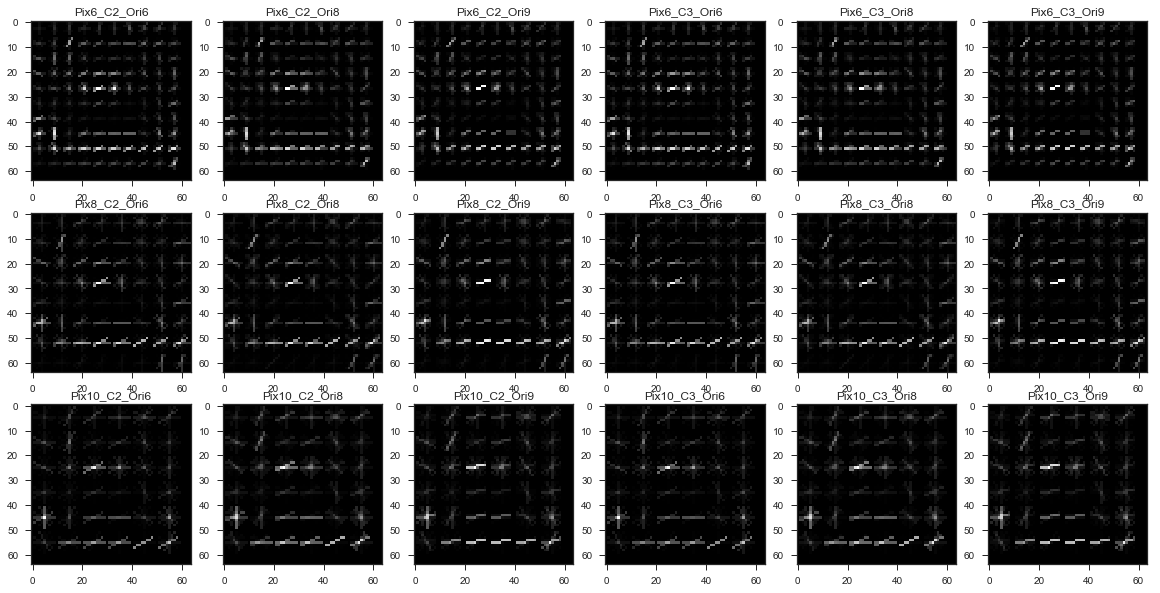

In [2]:
fig = plt.figure(figsize=(20, 10))

img = cv2.imread("./dataset/vehicles/GTI_Far/image0000.png")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

for i1,pix_per_cell in enumerate([6,8,10]):
    for i2,cell_per_block in enumerate([2,3]):
        for i3,orient in enumerate([6,8,9]):
            features, hog_image = hog(img_gray, pixels_per_cell=(pix_per_cell,pix_per_cell), 
                               cells_per_block=(cell_per_block,cell_per_block),
                               orientations=orient, visualise=True, feature_vector=False
                         )
            #print(features.shape)
            ax = fig.add_subplot(3,6,i1*6+i2*3+i3+1)
            ax.imshow(hog_image, 'gray')
            ax.set_title("Pix%d_C%d_Ori%d" % (pix_per_cell, cell_per_block, orient))
        

In [3]:
pix_per_cell = 8
cell_per_block = 2
orient = 9


For the second step, the HOG features were extracted from all possible channel of images. However, as the channels were too much, which made the downstream calculation slowly and memory-usage too high, **only gray channel were used** in this case.


In [4]:
l_samp = !ls ./dataset/*vehicles/*/*

M_ClassDict = {"non-vehicles" : 0, "vehicles" : 1}
pd_SampClass = pd.DataFrame({
    "Sample" : l_samp, 
    "Class"   : list(map(lambda x: M_ClassDict[x], list(map(lambda x: x.split("/")[2], l_samp))))
})[['Sample', 'Class']]


# Here, [0:1] for GRAY channel only, ignoring other channels.
l_colorSpace = [cv2.COLOR_BGR2GRAY, cv2.COLOR_BGR2RGB, cv2.COLOR_BGR2HLS, 
                cv2.COLOR_BGR2HLS, cv2.COLOR_BGR2LAB, cv2.COLOR_BGR2LUV, 
                cv2.COLOR_BGR2YCrCb, cv2.COLOR_BGR2YUV][0:1]
l_names = ["GRAY", "RGB", "HLS", "HLS", "LAB", "LUV", "YCrCb", "YUV"][0:1]
l_len   = [1,       3,     3,     3,       3,    3,    3,       3   ][0:1]

l_titles = []
for idx,name in enumerate(l_names):
    for rep in range(l_len[idx]):
        l_titles.append("%s_%d" % (name, rep))
        

## 1.3 Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).



I trained the SVC classifier with RBF kernel by first using the udacity official vehicle and non-vehicle dataset,  and I got a high accuracy in both training set and testing set.

In [5]:
# generate training data:

pd_SampClass_train,pd_SampClass_cv = train_test_split(pd_SampClass, test_size=0.33, random_state=42)

if os.path.isfile("./X_train.npy") == 0:
    l_X_train = []
    l_X_test  = []
    for r in tqdm(pd_SampClass_train.iterrows()):
        l_X_train.append(np.array(get_features(r[1]['Sample'])).ravel())

    for r in tqdm(pd_SampClass_cv.iterrows()):
        l_X_test.append( np.array(get_features(r[1]['Sample'])).ravel())
    
    X_train = np.array(l_X_train)
    X_test  = np.array(l_X_test)
    np.save("./X_train.npy", X_train)
    np.save("./X_test.npy",  X_test)
else:
    X_train = np.load("./X_train.npy")
    X_test  = np.load("./X_test.npy")
    
X_scaler1 = StandardScaler()
X_trainT = X_scaler1.fit_transform(X_train[:,0:1764])
X_testT  = X_scaler1.transform(X_test[:,0:1764])
y_train = pd_SampClass_train['Class'].values
y_test  = pd_SampClass_cv['Class'].values



In [6]:
svcLess = SVC(random_state=0, C=1)
# Check the training time for the SVC
t=time.time()
svcLess.fit(X_trainT, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svcLess.score(X_testT, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svcLess.predict(X_testT[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()

52.88 Seconds to train SVC...
Test Accuracy of SVC =  0.991
My SVC predicts:  [1 1 1 0 0 0 0 1 1 1]
For these 10 labels:  [1 1 1 0 0 0 0 1 1 1]


To further testing the accuracy of the model in other dataset, I generated some images from Autti dataset as the extra testing set. However, it seemed the false-positive rate is quite high for this extra dataset.


In [7]:
mAuti = m_Auti.dataArgumentForAutti(annoFile="./dataset/object-dataset/labels.csv", 
                                    root_dir="/dataset/object-dataset", ratio_nonCars=5)
pd_Extra = mAuti.generateExtraFile("./dataset/object-dataset_argument.csv")
pd_Extra

,0,1,2,3,name,tags
0,950,574,1004,620,1478019952686311006.jpg,1
1,872,586,926,632,1478019953180167674.jpg,1
2,686,566,728,618,1478019953689774621.jpg,1
3,716,578,764,622,1478019953689774621.jpg,1
4,826,580,880,626,1478019953689774621.jpg,1
5,1540,488,1680,608,1478019953689774621.jpg,1
6,1646,498,1848,594,1478019953689774621.jpg,1
7,662,562,710,616,1478019954186238236.jpg,1
8,686,576,730,628,1478019954186238236.jpg,1
9,802,582,856,628,1478019954186238236.jpg,1


The non-vehicle required the resulting boxes(blue) could not overlap with any vehicle boxes(Red) on the graph, and the window size for a non-vehicle was determined by a gamma distrubution estimated from the box-size of vehicles:

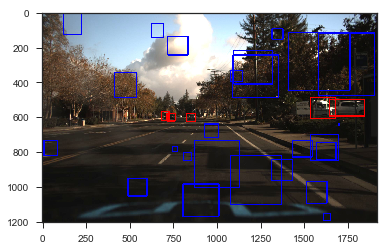

In [8]:
plt.imshow(m_Auti.plotArgumentationInRaw("1478019953689774621.jpg", pd_Extra))

0 out of 4
1 out of 4
2 out of 4
3 out of 4


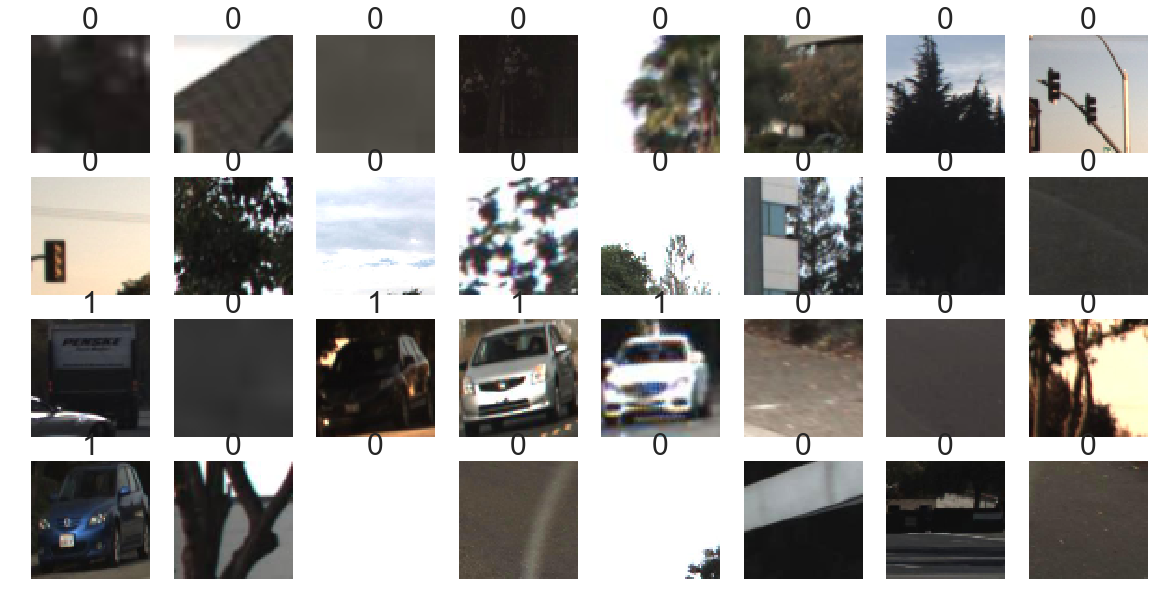

In [9]:
a1,a2 = next(m_Auti.generator(pd_Extra, batch_size=400))
fig = plt.figure(figsize=(20,10))
for i in range(32):
    ax = fig.add_subplot(4,8,i+1)
    ax.imshow(a1[i])
    ax.set_axis_off()
    ax.set_title(a2[i], size=30)

In [10]:
l_extraTest = []
for img in tqdm(a1):
    l_extraTest.append(get_features(img, inputFile=False)[0])

extra_pred = svcLess.predict(X_scaler1.transform(l_extraTest))
uda_pred = svcLess.predict(X_testT)
print("AUC for extra dataset = %1.2f,\nAUC for udacity dataset = %1.2f " % (roc_auc_score(extra_pred, a2), 
                                                                             roc_auc_score(uda_pred, y_test)))

print(confusion_matrix(extra_pred, a2))

100%|██████████| 400/400 [00:04<00:00, 85.68it/s]


AUC for extra dataset = 0.89,
AUC for udacity dataset = 0.99 
[[307  27]
 [  9  57]]


So I decided to adding some images in Autti dataset to reducing the False positive rate of this model. 

In [11]:
n_train = 20000
n_test = 4000

pd_ExtraSampClass_train,pd_ExtraSampClass_cv = train_test_split(pd_Extra, test_size=0.33, random_state=42)
X_trainRaw = np.load("./X_train.npy")
X_testRaw  = np.load("./X_test.npy")

if os.path.isfile("./X_trainExtra2.npy") == 0:
    Xtrain_Extra,Ytrain_Extra = next(generator(pd_ExtraSampClass_train.iloc[0:n_train], 
                                                       batch_size=n_train))
    Xcv_Extra,   Ycv_Extra    = next(generator(pd_ExtraSampClass_cv.iloc[0:n_test],    
                                                       batch_size=n_test))

    l_X_train = []
    l_X_test  = []
    for img in tqdm(Xtrain_Extra):
        l_X_train.append(np.array(get_features(img, inputFile=False)).ravel())

    for r in tqdm(Xcv_Extra):
        l_X_test.append( np.array(get_features(img, inputFile=False)).ravel())
    
    X_trainExtraRaw = np.array(l_X_train)
    X_testExtraRaw  = np.array(l_X_test)
    np.save("./X_trainExtra2.npy", X_trainExtraRaw)
    np.save("./X_testExtra2.npy",  X_testExtraRaw)
    np.save("./Y_trainExtra2.npy", Ytrain_Extra)
    np.save("./Y_testExtra2.npy",  Ycv_Extra)
else:
    X_trainExtraRaw = np.load("./X_trainExtra2.npy")
    X_testExtraRaw  = np.load("./X_testExtra2.npy")
    Ytrain_Extra = np.load("./Y_trainExtra2.npy")
    Ycv_Extra    = np.load("./Y_testExtra2.npy")
    
X_trainExtra22 = np.vstack([X_trainExtraRaw[Ytrain_Extra==1], X_trainExtraRaw[Ytrain_Extra==0][0:4000,:]])
Y_trainExtra22 = np.array([1 for i in range(3310)] + [0 for i in range(4000)])

X_trainMerge = np.vstack([X_trainRaw[:,0:1764], X_trainExtra22])
X_testMerge  = np.vstack([X_testRaw[:,0:1764],  X_testExtraRaw])

X_scalerM = StandardScaler()
X_trainMergeT = X_scalerM.fit_transform(X_trainMerge[:,0:1764])
X_testMergeT  = X_scalerM.transform(X_testMerge[:,0:1764])

y_trainMergeT = np.array(list(y_train) + list(Y_trainExtra22))
y_testMergeT  = np.array(list(y_test)  + list(Ycv_Extra))
X_trainMergeTs,y_trainMergeTs = sklearn.utils.shuffle(X_trainMergeT, y_trainMergeT)


In [12]:

if not os.path.isfile("./MySVCModel.merge.pkl"):
    svcMerge = SVC(random_state=0, C=1)
    t=time.time()
    svcMerge.fit(X_trainMergeTs, y_trainMergeTs)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    sMerge = pickle.dump(svcMerge, open("MySVCModel.merge.pkl", 'wb'))
else:
    svcMerge = pickle.load(open("MySVCModel.merge.pkl", 'rb'))
    

In [13]:
print('Test Accuracy of SVC = ', round(svcMerge.score(X_testMergeT, y_testMergeT), 4))
t=time.time()
n_predict = 10
print('My SVC predicts: ', svcMerge.predict(X_testMergeT[0:n_predict]))
print('For these',n_predict, 'labels: ', y_testMergeT[0:n_predict])
t2 = time.time()

merge_pred = svcMerge.predict(X_testMergeT)
print("AUC for Merge dataset = %1.2f,\n" % (roc_auc_score(merge_pred, y_testMergeT)))
print(confusion_matrix(merge_pred, y_testMergeT))

Test Accuracy of SVC =  0.926
My SVC predicts:  [1 1 1 0 0 0 0 1 1 1]
For these 10 labels:  [1 1 1 0 0 0 0 1 1 1]
AUC for Merge dataset = 0.94,

[[6258  689]
 [  41 2873]]


The AUC value for the new dataset is much more improved. So this new model were used for the next Sliding Window Search section

# 2. Sliding Window Search

## 2.1. Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?

As was shown below, the window-searching algorithm is that a searching window with 96px in width and 96px in height were used to slide the images from `y=400` to `y=656`. 

The step of the searching window is 24px, one fourth of the window size, and was walked along the whole searching region from up-down. The second searching window were marked as red in the resulting picture.

When all window in a single column were searched(12 windows in total), it would move 24px to the right and searched the next column. The first searching window in this new column were marked as green in the resulting picture.

In [14]:
def allBoxesInImage(img, pix_per_cell=8,cell_per_block=2,orient=9,
                          ystart=400,ystop=656,scale=1.5,RGB2BGR=True):
    
    img_tosearch = img[ystart:ystop,:,:]
    imshape = img_tosearch.shape
    if scale != 1:
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    nxblocks = (imshape[1] // pix_per_cell)-1
    nyblocks = (imshape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2

    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    l_boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            l_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
             
    return l_boxes


((0, 400), (96, 496)) ((0, 424), (96, 520)) ((24, 400), (120, 496))


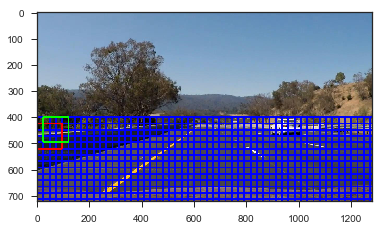

In [15]:
img = cv2.imread("./test_extra/project_500.jpeg")
l_boxout = allBoxesInImage(img, pix_per_cell=8,cell_per_block=2,orient=9,
                                     ystart=400,ystop=656,scale=1.5,RGB2BGR=False)

m_allBlue = m_Auti.draw_boxes(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 
                      list(map(lambda x: [x[0][0], x[0][1], x[1][0], x[1][1]], l_boxout))
)
m_oneRed = m_Auti.draw_boxes(m_allBlue, 
                      list(map(lambda x: [x[0][0], x[0][1], x[1][0], x[1][1]], l_boxout[1:2])), color=(255,0,0)
)
m_oneRedGreen = m_Auti.draw_boxes(m_oneRed, 
                      list(map(lambda x: [x[0][0], x[0][1], x[1][0], x[1][1]], l_boxout[12:13])), color=(0,255,0)
)
plt.imshow(m_oneRedGreen)
print(l_boxout[0], l_boxout[1], l_boxout[12])

## 2.2. Show some examples of test images to demonstrate how your pipeline is working. What did you do to optimize the performance of your classifier?

I chosed some pictures from the movie `project_video.mp4` as the testing images. The HOG features using the well-tuned parameters in gray channel seemed to perform well in these testing images: 

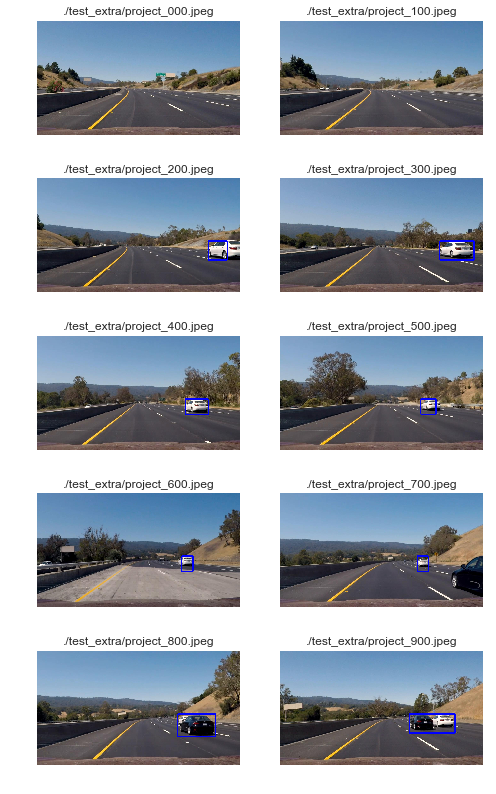

In [16]:
def processImg(img, cvt=False):
    l_boxout = parseBoxesInImageLess(img, svcMerge, X_scalerM, pix_per_cell=8,cell_per_block=2,orient=9,
                                     ystart=400,ystop=656,scale=1.5,RGB2BGR=True)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,l_boxout)
    heat = apply_threshold(heat,1)
    heatmap = np.clip(heat, 0, 255)


    labels = label(heatmap)
    if cvt:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    draw_img = draw_labeled_bboxes(img, labels)
    return draw_img

l_drawImgs = []
l_images = !ls ./test_extra/*
for image in l_images:
    img = cv2.imread(image)
    draw_img = processImg(img,cvt=True)
    l_drawImgs.append(draw_img)


fig = plt.figure(figsize=(8,14))
for i,title in enumerate(l_images):
    ax = fig.add_subplot(5,2,i+1)
    ax.imshow(l_drawImgs[i])
    ax.set_title(title)
    ax.set_axis_off()

# 3. Video Implementation

## 3.1. Provide a link to your final video output. 

I first tested my video directly using the `processImg` function described previously. Results were shown in this page:

- test_video_result.mp4
- project_video_result.mp4

In [17]:
from moviepy.editor import VideoFileClip

def process_video (input_path, output_path):
    clip = VideoFileClip (input_path)
    result = clip.fl_image(processImg)
    %time result.write_videofile(output_path, audio=False)

#process_video ('test_video.mp4', 'test_video_result.mp4')
#process_video ('project_video.mp4', 'project_video_result.mp4')

However, there were too many false positives on the project movie. So I just used a 10-window constitude heatmap instead the present heatmap, and the False positive were much lower:

- test_video_result.mp4
- project_video_result.Smooth.mp4

Note that I did not clear `self.l_heats` after processing `test_video`, so there were some False positive boxes at the very beginning of my `project_video`. As the processsing time is quite long, I did not re-run that.

In [18]:
class smoothProcess(object):
    def __init__(self):
        self.l_heats = []
    
    
    def processImgSmooth(self, img):

        l_boxout = parseBoxesInImageLess(img, svcMerge, pix_per_cell=8,cell_per_block=2,orient=9,
                                     ystart=400,ystop=656,scale=1.5,RGB2BGR=True)
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        heat = add_heat(heat,l_boxout)
        self.l_heats.append(heat)
        if len(self.l_heats) > 100:
            self.l_heats = self.l_heats[-20:]
    
        # Apply threshold to help remove false positives
        heatSmooth = np.array(self.l_heats[-10:]).mean(0)
        #print(heat.shape, heatSmooth.shape)
        heat2 = apply_threshold(heatSmooth,1)
    
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat2, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        #
        draw_img = draw_labeled_bboxes(img, labels)
        return draw_img

    

def process_videoSmooth (input_path, output_path):
    clip = VideoFileClip (input_path)
    result = clip.fl_image(mpis.processImgSmooth)
    %time result.write_videofile(output_path, audio=False)


mpis = smoothProcess()
#process_videoSmooth('test_video.mp4', 'test_video_result.Smooth.mp4')
#mpis = smoothProcess() ## should do this, but did not, 
                        ## which introduced some FP at the beginning of project_video_result.Smooth.mp4
    
#process_videoSmooth('project_video.mp4', 'project_video_result.Smooth.mp4')


## 3.2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video. 

From the positive detections I created a heatmap(Left) and then thresholded that map to identify vehicle positions(middle). 

Finnaly, I used scipy.ndimage.measurements.label() to identify individual blobs in the heatmap. I then assumed each blob corresponded to a vehicle(right):

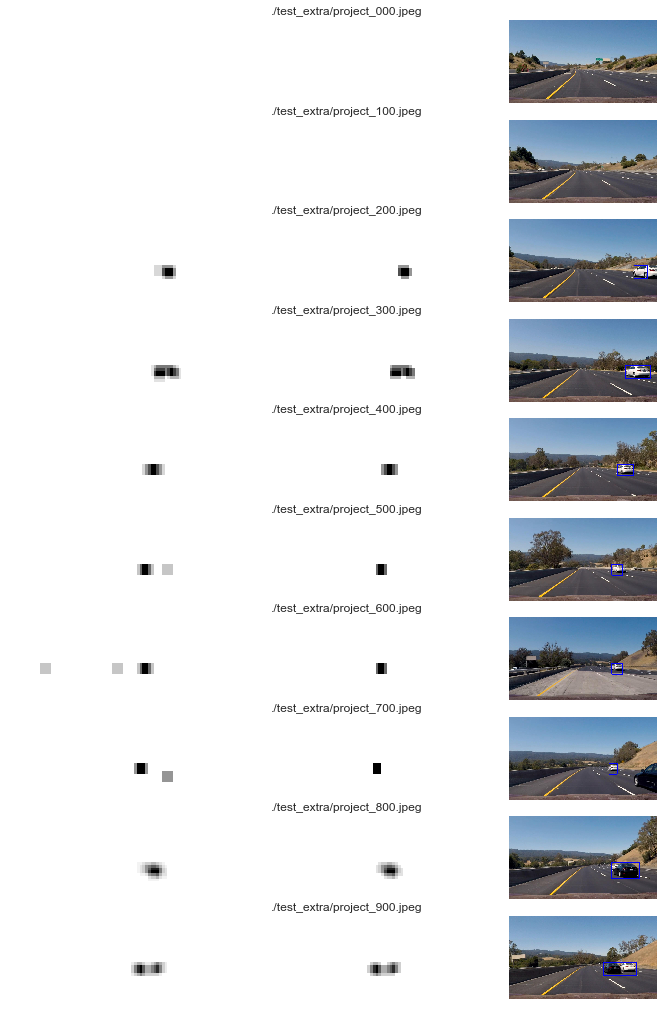

In [20]:
%matplotlib inline
sns.set_style("ticks")
fig = plt.figure(figsize=(12, 18))

for i,title in enumerate(l_images):
    ax1 = fig.add_subplot(len(l_images),3,3*i+1)
    ax2 = fig.add_subplot(len(l_images),3,3*i+2)
    ax3 = fig.add_subplot(len(l_images),3,3*i+3)
    img = cv2.imread(l_images[i])

    l_boxout = parseBoxesInImageLess(img, svcMerge, X_scalerM, pix_per_cell=8,cell_per_block=2,orient=9,
                                     ystart=400,ystop=656,scale=1.5,RGB2BGR=False)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,l_boxout)
    heatTmp = heat.copy()

    heat = apply_threshold(heat,1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes( cv2.cvtColor(img, cv2.COLOR_BGR2RGB), labels)
    
    ax1.imshow(heatTmp)
    #ax1.set_title(title)
    ax1.set_axis_off()
    
    ax2.imshow(heat)
    ax2.set_title(title)
    ax2.set_axis_off()
    
    ax3.imshow(draw_img)
    #ax3.set_title(title)
    ax3.set_axis_off()